# Feature Selection,Model Training and Evaluation

**Import Libraries**

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error,r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
import shap
import joblib as jb

In [15]:
df=pd.read_csv("../data/clean.csv")

In [16]:
df.columns

Index(['TRIP_DURATION', 'DISTANCE_TRAVELED', 'NUM_OF_PASSENGERS', 'FARE',
       'TIP', 'MISCELLANEOUS_FEES', 'TOTAL_FARE', 'SURGE_APPLIED'],
      dtype='object')

*Since were predicting FARE only and not TOTAL_FARE we drop the features that are not dependent on FARE and select the necessary features* **'TRIP_DURATION', 'DISTANCE_TRAVELED', 'NUM_OF_PASSENGERS', 'TIP', 'MISCELLANEOUS_FEES' 'SURGE_APPLIED'**
*We drop Total Fare because TOTAL_FARE = FARE + TIP + MISCELLANEOUS_FEES*

In [17]:
df.drop(columns=["TOTAL_FARE"],inplace=True)

In [18]:
df.head(5)

,TRIP_DURATION,DISTANCE_TRAVELED,NUM_OF_PASSENGERS,FARE,TIP,MISCELLANEOUS_FEES,SURGE_APPLIED
0,1848,5,1,143,17,26,1
1,319,2,1,41,0,27,1
2,962,13,1,180,37,6,0
3,718,5,1,94,0,6,0
4,626,3,2,68,19,26,1


Separate Labels and Target

In [19]:
y=df["FARE"]
x=df.drop(columns="FARE")

Split into Testing and Training Sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)

Scaling Features for Linear and Distance based Models

In [21]:
st=StandardScaler()
X_train_scaled=st.fit_transform(X_train)
X_test_scaled=st.transform(X_test)

**Linear Regression**

In [22]:
lg=LinearRegression()
lg.fit(X_train_scaled,y_train)
y_pred_lg=lg.predict(X_test_scaled)

rmse_lg=root_mean_squared_error(y_test,y_pred_lg)
r2_lg=r2_score(y_test,y_pred_lg)

**Support Vector Regression**

In [23]:
sv=SVR()
sv.fit(X_train_scaled,y_train)
y_pred_sv=sv.predict(X_test_scaled)

rmse_sv=root_mean_squared_error(y_test,y_pred_sv)
r2_sv=r2_score(y_test,y_pred_sv)

**Random Forest**

In [24]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

rmse_rf=root_mean_squared_error(y_test,y_pred_rf)
r2_rf=r2_score(y_test,y_pred_rf)

**Xgboost**

In [25]:
xg=XGBRegressor(n_estimators=500,learning_rate=0.05)
xg.fit(X_train,y_train)
y_pred_xg=xg.predict(X_test)

rmse_xg=root_mean_squared_error(y_test,y_pred_xg)
r2_xg=r2_score(y_test,y_pred_xg)

**LightGBM**

In [34]:
lgbm=LGBMRegressor(n_estimators=500,learning_rate=0.05)
lgbm.fit(X_train,y_train)
y_pred_lgbm=lgbm.predict(X_test)

rmse_lgbm=root_mean_squared_error(y_test,y_pred_lgbm)
r2_lgbm=r2_score(y_test,y_pred_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 116487, number of used features: 6
[LightGBM] [Info] Start training from score 112.496776


**MODEL COMPARISON**

In [27]:
metrics=pd.DataFrame({
"Models":["LinearRegression","SVR","RandomForest","Xgboost","LightGBM"],
"R2":[r2_lg,r2_sv,r2_rf,r2_xg,r2_lgbm],
"RMSE":[rmse_lg,rmse_sv,rmse_rf,rmse_xg,rmse_lgbm]
})

In [28]:
metrics.sort_values(by="R2",ascending=False)

,Models,R2,RMSE
4,LightGBM,0.910045,25.129141
3,Xgboost,0.908210,25.384193
2,RandomForest,0.885681,28.328522
0,LinearRegression,0.816725,35.868715
1,SVR,0.760160,41.032290


In [29]:
print(metrics.sort_values(by="R2",ascending=False))

             Models        R2       RMSE
4          LightGBM  0.910045  25.129141
3           Xgboost  0.908210  25.384193
2      RandomForest  0.885681  28.328522
0  LinearRegression  0.816725  35.868715
1               SVR  0.760160  41.032290


*We clearly see that the Boosting models **XGBOOST** and **LightBGM** outperform the rest of the models **Random Forest** performance was solid but not as good as the boosting models linear regression was also a good baseline*

**HYPERPARAMETER OPTIMIZATION**

In [ ]:

from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    "max_depth": [3, 5, 8, 10],
    "min_child_weight": [1, 3, 5], 
    "learning_rate": [0.01, 0.05, 0.1], 
    "n_estimators": [300, 500, 800], 
    "subsample": [0.7, 0.8, 1.0], 
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2] 
}

lgbm_params = {
    "num_leaves": [31, 63, 127, 255], 
    "max_depth": [-1, 5, 10, 20], 
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_samples": [5, 10, 20]
}


xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)
xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, scoring="r2", cv=3, n_jobs=-1, verbose=0, random_state=42
)


lgbm = LGBMRegressor(random_state=42)
lgbm_search = RandomizedSearchCV(
    lgbm, lgbm_params, n_iter=20, scoring="r2", cv=3, n_jobs=-1, verbose=-1, random_state=42
)


xgb_search.fit(X_train, y_train)
lgbm_search.fit(X_train, y_train)

print("XGBoost Best:", xgb_search.best_params_, xgb_search.best_score_)
print("LightGBM Best:", lgbm_search.best_params_, lgbm_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 116487, number of used features: 6
[LightGBM] [Info] Start training from score 112.496776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [38]:
lgbm=LGBMRegressor(n_estimators=500,learning_rate=0.05)
lgbm.fit(X_train,y_train)
y_pred_lgbm=lgbm.predict(X_test)

rmse_lgbm=root_mean_squared_error(y_test,y_pred_lgbm)
r2_lgbm=r2_score(y_test,y_pred_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 116487, number of used features: 6
[LightGBM] [Info] Start training from score 112.496776


In [ ]:
lgbm=LGBMRegressor(n_estimators=500,learning_rate=0.05)
lgbm.fit(X_train,y_train)
y_pred_lgbm=lgbm.predict(X_test)

rmse_lgbm=root_mean_squared_error(y_test,y_pred_lgbm)
r2_lgbm=r2_score(y_test,y_pred_lgbm)

*The Hyperparamter optimization led to underfitting by the models and the base models have a higher R2*
**Results Baseline XGBoost: R² ≈ 0.908, RMSE ≈ 25.38 Tuned XGBoost: R² ≈ 0.888 (worse) Baseline LightGBM: R² ≈ 0.910 RMSE ≈ 25.13 Tuned LightGBM: R² ≈ 0.891 (worse)**

**FEATURE IMPORTANCE**

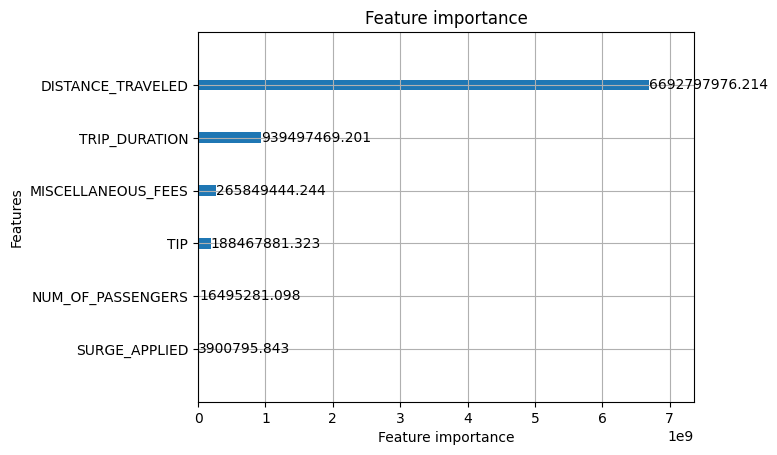

In [35]:
lgb.plot_importance(lgbm, max_num_features=10, importance_type="gain")
plt.show()

In [36]:
explainer=shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

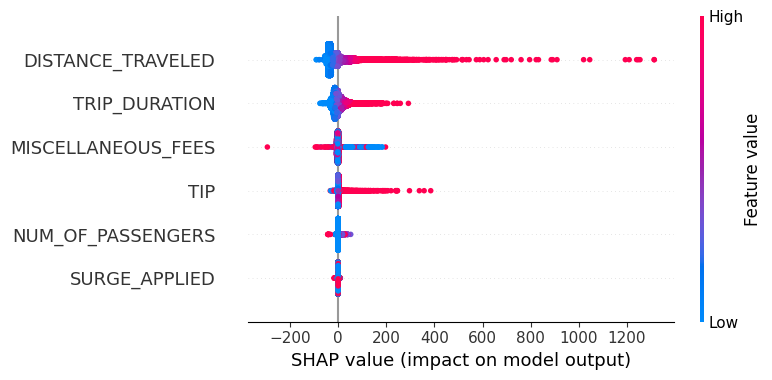

In [37]:
shap.summary_plot(shap_values, X_test)

**Export Model**

In [ ]:
jb.dump(lgbm,"../models/lightgbm.pkl")

['../models/lightgbm.pkl']

In [39]:
X_train.columns

Index(['TRIP_DURATION', 'DISTANCE_TRAVELED', 'NUM_OF_PASSENGERS', 'TIP',
       'MISCELLANEOUS_FEES', 'SURGE_APPLIED'],
      dtype='object')